<a href="https://www.kaggle.com/code/clydenarciso/breast-cancer-detection-via-supervised-learning?scriptVersionId=255105371" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Hey there👋 I see you're curious, just like me!**

I'm Clyde Narciso from the University of the Philippines Los Baños. Join me in this journey of problem-solving and potentially life-saving!

In this project, we are given the responsibility of accurately and automatically detecting cancer using machine learning tools!

We have a dataset 'Breast_cancer_dataset.csv' containing features derived from digitized images of fine needle aspirates (FNA) of breast masses, and labels of 'Benign' or 'Malignant'.

Our job is to create a machine learning model that will classify the sample as cancerous or not, given the sample's feature values.

In [1]:
import numpy as np
import pandas as pd 

# Read the dataset into a pandas DataFrame!
df = pd.read_csv('/kaggle/input/breast-cancer-dataset/Breast_cancer_dataset.csv')

In [2]:
# Separate the feature and target variables
columns_to_drop = ['id', 'diagnosis', 'Unnamed: 32']
X = df.drop(columns_to_drop, axis=1)
y = df['diagnosis']

# Convert categorical target variable to binary dummy variables
y_num = pd.get_dummies(y, dtype=int)
# Since a sample can only be either 'B' or 'M' and never both, we can discard a column to reduce dimensionality
y_num = y_num.drop('B', axis=1)

# Convert the DataFrame into a 1D NumPy array
y_num = y_num.values.ravel()

In [3]:
# Import the goodz
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Initializing preprocessing tools
scaler = StandardScaler()

# Splitting the test and training data
X_test, X_train, y_test, y_train = train_test_split(X, y_num, test_size=0.3, stratify=y_num, random_state=1)

# Preprocessing the training and test data
X_train_preprocessed = scaler.fit_transform(X_train)
X_test_preprocessed = scaler.fit_transform(X_test)

In [4]:
# Import some more goodz
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold

# Performing GridSearchCV to optimize the hyperparameter
splits = 5 # this is arbitrarily chosen
kf = KFold(n_splits=splits, shuffle=True, random_state=1)
knn_param_grid = {'n_neighbors': range(1,26)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_param_grid, cv=kf)
knn_cv.fit(X_train_preprocessed, y_train)
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 9} 0.9411764705882353


We choose n_neighbors = 9!

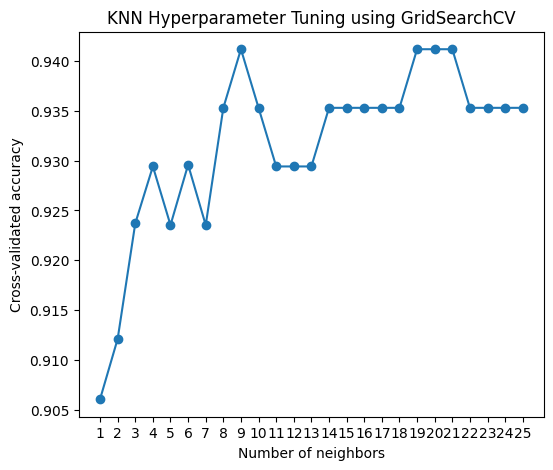

In [5]:
# Visualizing the Hyperparameter Tuning
import matplotlib.pyplot as plt

knn_results_df = knn_cv.cv_results_['mean_test_score']
n_neighbors = knn_param_grid['n_neighbors']

plt.figure(figsize=(6,5))
plt.plot(n_neighbors, knn_results_df, marker='o')
plt.xlabel('Number of neighbors')
plt.ylabel('Cross-validated accuracy')
plt.title('KNN Hyperparameter Tuning using GridSearchCV')
plt.xticks(n_neighbors)
plt.show()

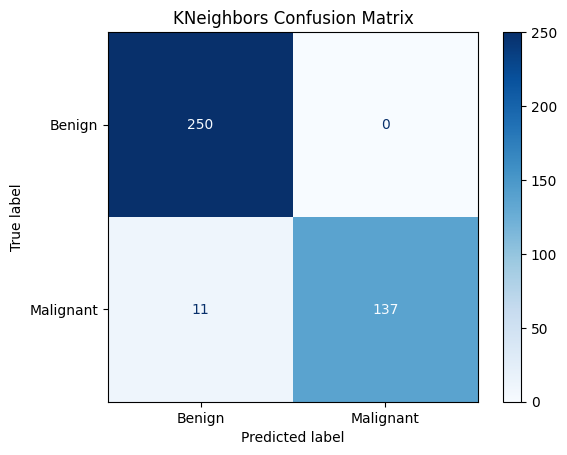

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       250
           1       1.00      0.93      0.96       148

    accuracy                           0.97       398
   macro avg       0.98      0.96      0.97       398
weighted avg       0.97      0.97      0.97       398



In [6]:
# Construct the confusion matrix and classification report to evaluate our model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

knn_y_pred = knn_cv.predict(X_test_preprocessed)

conf_matrix = confusion_matrix(y_test, knn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('KNeighbors Confusion Matrix')
plt.show()
print(classification_report(y_test, knn_y_pred))

We have 11 cases of False Negatives, meaning our model predicted the tumor was benign, when it was actually malignant.

This is unacceptable! Let's try Logistic Regression this time.

In [7]:
# We will now try Logistic Regression and see if it yields better results
from sklearn.linear_model import LogisticRegression

# Performing GridSearchCV to find optimize the hyperparameters 
# (strength of regularization (C) and regularization techniques (l1 or l2))
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'], 
                'max_iter' : [100, 200, 500, 1000]}
lr = LogisticRegression(solver='liblinear')
lr_cv = GridSearchCV(lr, lr_param_grid, cv=kf)
lr_cv.fit(X_train_preprocessed, y_train)
print(lr_cv.best_params_, lr_cv.best_score_)

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2'} 0.9529411764705882


We choose C = 0.1, and regularization technique = l2 (Ridge regression)!

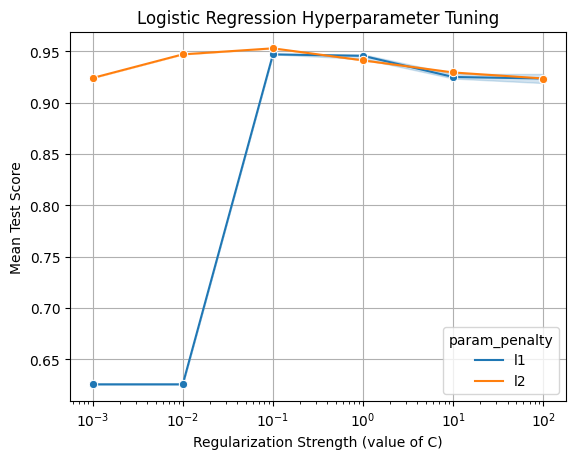

In [8]:
# Visualizing the hyperparameter tuning for Logistic Regression
import seaborn as sns
# Seaborn was giving me FutureWarnings so I'm just doing this as a bandaid solution
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the results into a DataFrame
lr_results_df = pd.DataFrame(lr_cv.cv_results_)

sns.lineplot(data=lr_results_df, x='param_C', y='mean_test_score', hue='param_penalty', marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (value of C)')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.title('Logistic Regression Hyperparameter Tuning')
plt.show()

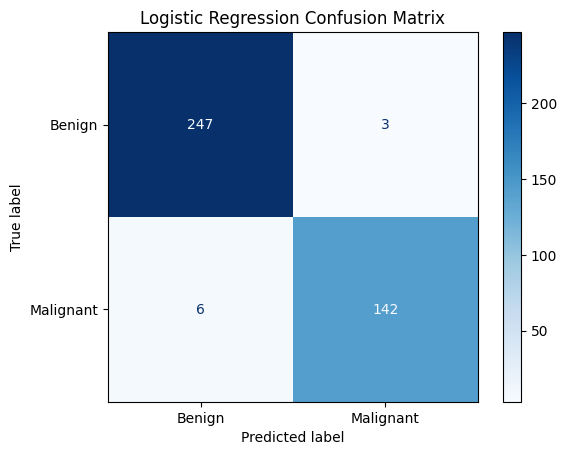

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       250
           1       0.98      0.96      0.97       148

    accuracy                           0.98       398
   macro avg       0.98      0.97      0.98       398
weighted avg       0.98      0.98      0.98       398



In [9]:
# Now let's use our model with the optimized hyperparameters and analyze the results!
lr_y_pred = lr_cv.predict(X_test_preprocessed)

conf_matrix = confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()
print(classification_report(y_test, lr_y_pred))

We have achieved better results with logistic regression compared to k-neighbors classification.

But there are 6 false negatives-- which is still unacceptable!

I wonder-- how can we achieve better results? 

I have to study more. Maybe better feature engineering or hyperparameter tuning?

For now, let's try the LinearSVC Classifier.

In [10]:
from sklearn.svm import LinearSVC

svm_param_grid = {'C': [0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.1, 1, 2]}
svm = LinearSVC()
svm_cv = GridSearchCV(svm, svm_param_grid, cv=kf)
svm_cv.fit(X_train_preprocessed, y_train)
print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 0.006} 0.9529411764705882


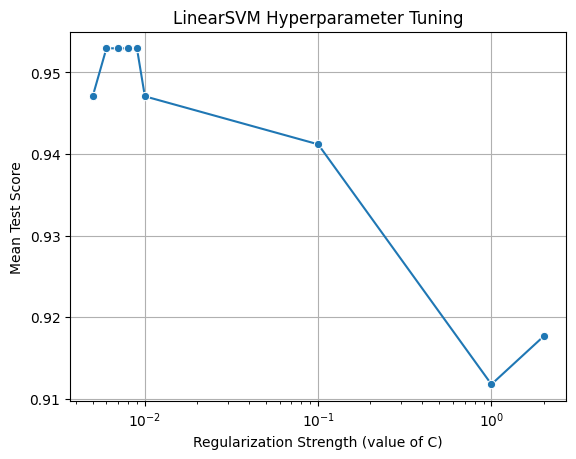

In [11]:
# Load the results into a DataFrame
svm_results_df = pd.DataFrame(svm_cv.cv_results_)

sns.lineplot(data=svm_results_df, x='param_C', y='mean_test_score', marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (value of C)')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.title('LinearSVM Hyperparameter Tuning')
plt.show()

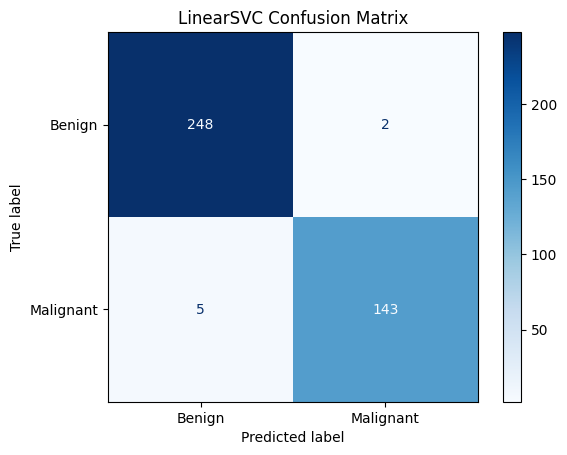

              precision    recall  f1-score   support

           0     0.9802    0.9920    0.9861       250
           1     0.9862    0.9662    0.9761       148

    accuracy                         0.9824       398
   macro avg     0.9832    0.9791    0.9811       398
weighted avg     0.9825    0.9824    0.9824       398



In [12]:
# Now let's use our model with the optimized hyperparameters and analyze the results!
svm_y_pred = svm_cv.predict(X_test_preprocessed)

conf_matrix = confusion_matrix(y_test, svm_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('LinearSVC Confusion Matrix')
plt.show()
print(classification_report(y_test, svm_y_pred, digits=4))

Now, there are 5 False Negatives, which is a slight improvement compared to Logistic Regression. The accuracy is 98.24%.


This is the best we can do so far. I will have to study more to get better results!

# Thank you for going on this journey with me! -Clyde